In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify
%matplotlib inline
import seaborn as sns
import datetime

plt.style.use("ggplot")

# 期間開始日
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).astimezone()

item_condition_dic = {5: "S", 4: "A", 3:"B", 2: "C", 1: "D", 0:"J"}


In [5]:
sql = "SELECT * FROM aws_mysql_tables.clean_fleamarket_sales"
project_id = "##google bigquery projectId"
smartphone_data = pd.read_gbq(sql, project_id)

Downloading: 100%|██████████| 468204/468204 [00:45<00:00, 10309.67rows/s]


Import data from pickle


In [8]:
# smartphone_data.to_csv("../data/smartphone.csv", encoding="utf-8")
smartphone_data = pd.read_pickle("../data/smartphone.pkl")

# Create Bar Chart Race Data

In [28]:

df = smartphone_data[~smartphone_data["brand"].isna()]
df = df.set_index("sales_date").sort_index()
df = df.groupby(["brand_name", "maker"]).resample("1D").count().iloc[:,1]
# df = df.groupby("brand").cumsum()

In [29]:

df = df.reset_index()
df = df[df["sales_date"] >= start_date]
df["sales_date"] = df["sales_date"].dt.strftime('%Y/%m/%d')

# output csv
pd.pivot_table(df, index=["brand_name", "maker"], columns="sales_date").fillna(0).cumsum(axis=1).to_csv("iphone_data.csv", encoding="utf-8")


# create table data

In [107]:
# start date
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).astimezone()

# share by flema
flema_share_by_brands = pd.crosstab(smartphone_data["brand_name"] ,smartphone_data["data_type"], margins=True)
condition_share_by_brands = pd.crosstab(smartphone_data["brand_name"], smartphone_data["item_condition"], normalize="index").rename(columns=item_condition_dic)

# monthly counts
monthly_counts_by_brands = smartphone_data[smartphone_data["sales_date"] >= start_date].groupby("brand_name").resample("M" , on="sales_date").count().iloc[:,1].reset_index()
monthly_counts_by_brands["sales_date"] = monthly_counts_by_brands["sales_date"].dt.strftime("%Y-%m")
monthly_counts_by_brands = pd.pivot_table(monthly_counts_by_brands, index="brand_name", columns="sales_date")
monthly_counts_by_brands = monthly_counts_by_brands.fillna(0).cumsum(axis=1).droplevel(0, axis=1)

# mid price of new condition by brands
price_of_new_condition_by_brands = smartphone_data[smartphone_data["item_condition"] == 5].groupby("brand_name").median()[["price"]].rename(columns={"price": "new_price"})

# mid price of old condition by brands
price_of_old_condition_by_brands = smartphone_data[smartphone_data["item_condition"].isin([1,2,3,4])].groupby("brand_name").median()[["price"]].rename(columns={"price": "old_price"})

# join above tables
summary_table = price_of_new_condition_by_brands.join([price_of_old_condition_by_brands,
                                                       condition_share_by_brands,
                                                       monthly_counts_by_brands,
                                                       flema_share_by_brands
                                                       ]).reset_index()


In [110]:
# export csv
summary_table.to_csv("summary_table.csv", encoding="utf-8", index=None)

## Sub Page

In [148]:
["ALL"] + list(smartphone_data["brand_name"].value_counts()[:10].index)

['ALL',
 'iPhone 7',
 'iPhone 8',
 'iPhone SE',
 'iPhone 6s',
 'iPhone X',
 'iPhone 6',
 'iPhone XR',
 'iPhone XS',
 'iPhone 7 Plus',
 'iPhone 8 Plus']

In [117]:
top10 = smartphone_data["brand_name"].value_counts()[:10]

volumes = smartphone_data[smartphone_data["brand_name"] == brand]["volume"].unique()

brand = top10.index[1]
volume = volumes[1]

In [118]:
print(brand, volume)

iPhone 8 64GB


In [119]:

df = smartphone_data[(smartphone_data["brand_name"] == brand) & (smartphone_data["volume"] == volume)]
df = df[df["sales_date"] >= start_date]
ts = df.groupby("item_condition").resample("W", on="sales_date").mean()[["price"]]


In [120]:
ts = pd.pivot_table(ts, index="item_condition", columns="sales_date").stack().reset_index()

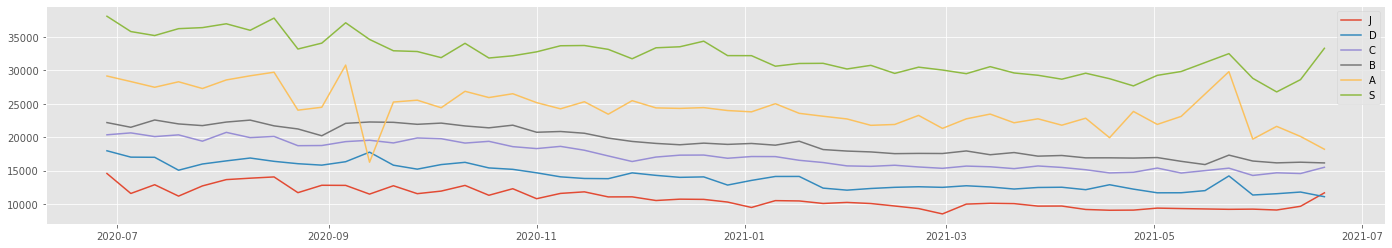

In [143]:
# timeseries plot
plt.figure(figsize=(24,4))
for condition in ts["item_condition"].unique():
    data = ts[ts["item_condition"] == condition].copy()
    plt.plot(data["sales_date"], data["price"], label=item_condition_dic[condition])
    plt.legend()

In [122]:
# stacked bar
monthly_counts = df.groupby("item_condition").resample("M", on="sales_date").count().iloc[:, 1].reset_index()
monthly_counts["sales_date"] = monthly_counts["sales_date"].dt.strftime("%Y-%m")
monthly_counts = pd.pivot_table(monthly_counts, index="item_condition", columns="sales_date").droplevel(0, axis=1)

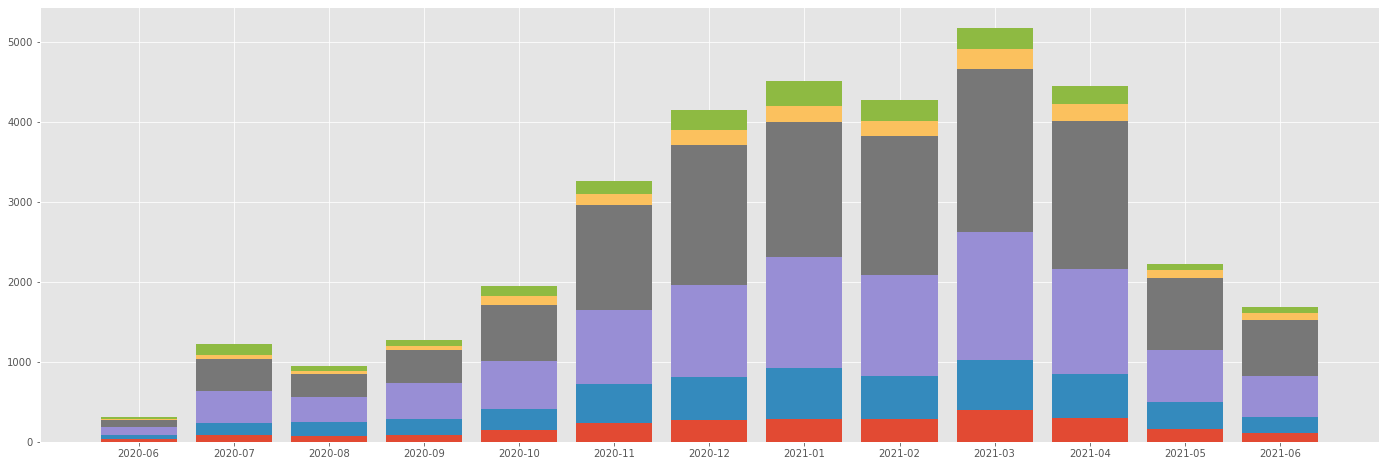

In [124]:
fig, ax = plt.subplots(figsize=(24, 8))
for i in range(len(monthly_counts)):
    ax.bar(monthly_counts.columns, monthly_counts.iloc[i], bottom=monthly_counts.iloc[:i].sum())

True     30164
False     5285
Name: sim_free_flg, dtype: int64


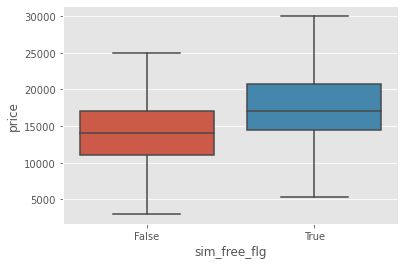

In [125]:
print(df["sim_free_flg"].value_counts())
sns.boxplot(df["sim_free_flg"], df["price"], sym="")

CIRCLE      15287
TRIANGLE     1432
CROSS         314
Name: restriction, dtype: int64


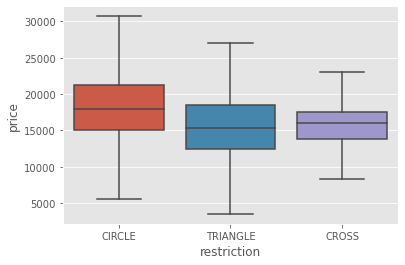

In [126]:
print(df["restriction"].value_counts())
sns.boxplot(df["restriction"], df["price"], sym="")